In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns

In [47]:
df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


In [48]:
df['ee_R'].quantile(0.99)

np.float64(74.10400077819826)

In [49]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


In [50]:
reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R']]
lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66


In [52]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

botorch_rdm_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

fps_recommender = FPSRecommender()
random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)
botorch_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_rdm_recommender)

fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=fps_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"GP FPS": botorch_fps_campaign,"GP rdm": botorch_rdm_campaign, "Random": random_campaign, "FPS": fps_campaign}


In [53]:
results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  5%|5         | 1/20 [00:48<15:14, 48.12s/it]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\s

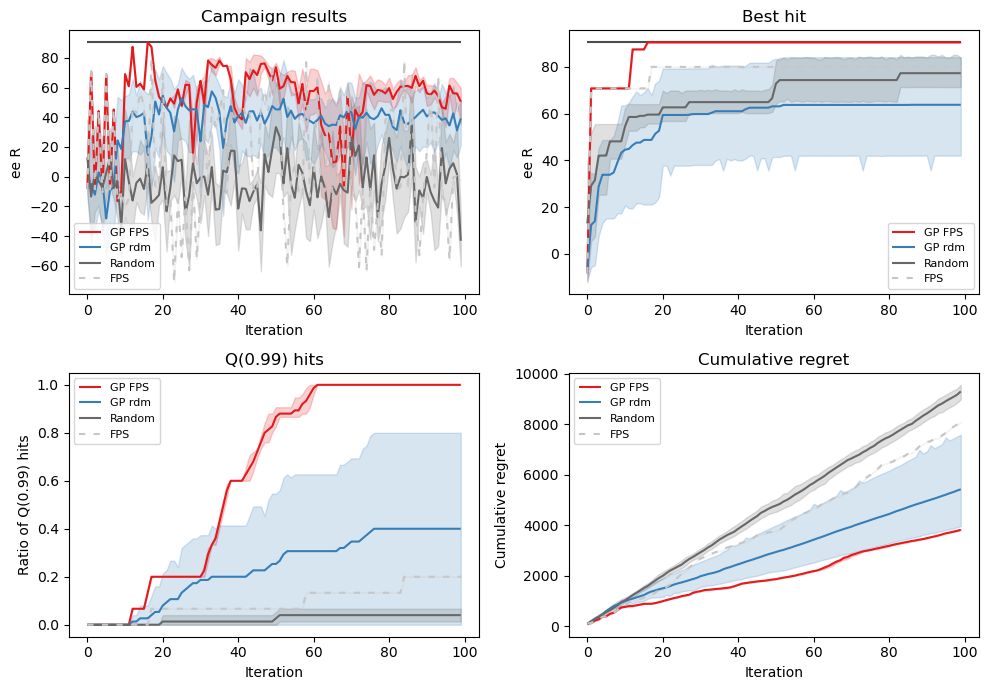

In [54]:
from utils import plot_results

plot_results(results, lookup, figure_name= 'init_bo.png', nbr_controls=2)


#### Surrogates

In [55]:
from baybe.surrogates import GaussianProcessSurrogate, RandomForestSurrogate, BayesianLinearSurrogate, NGBoostSurrogate, RandomForestSurrogate, MeanPredictionSurrogate


surrogates = {
    'Random forest': RandomForestSurrogate(),
    'Gaussian process': GaussianProcessSurrogate(),
    'Bayesian linear': BayesianLinearSurrogate(),
    'NGBoost': NGBoostSurrogate(),
    'Mean prediction': MeanPredictionSurrogate(),
}

def get_recommender(surrogate):
    recommender = TwoPhaseMetaRecommender(
        initial_recommender=FPSRecommender(),  # farthest point sampling
        recommender=BotorchRecommender(surrogate_model=surrogate),  # Bayesian model-based optimization
        switch_after=10,  # switch to Botorch after 10 iterations
        )
    return recommender

recommenders = {key: get_recommender(surrogate) for key, surrogate in surrogates.items()}
recommenders['random'] = RandomRecommender()

campaigns = {
    key: Campaign(searchspace=searchspace, objective=objective, recommender=recommender)
    for key, recommender in recommenders.items()
}


#print(campaigns)

In [56]:
BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

results = simulate_scenarios(
    campaigns,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

 20%|##        | 6/30 [03:42<14:49, 37.05s/it]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\s

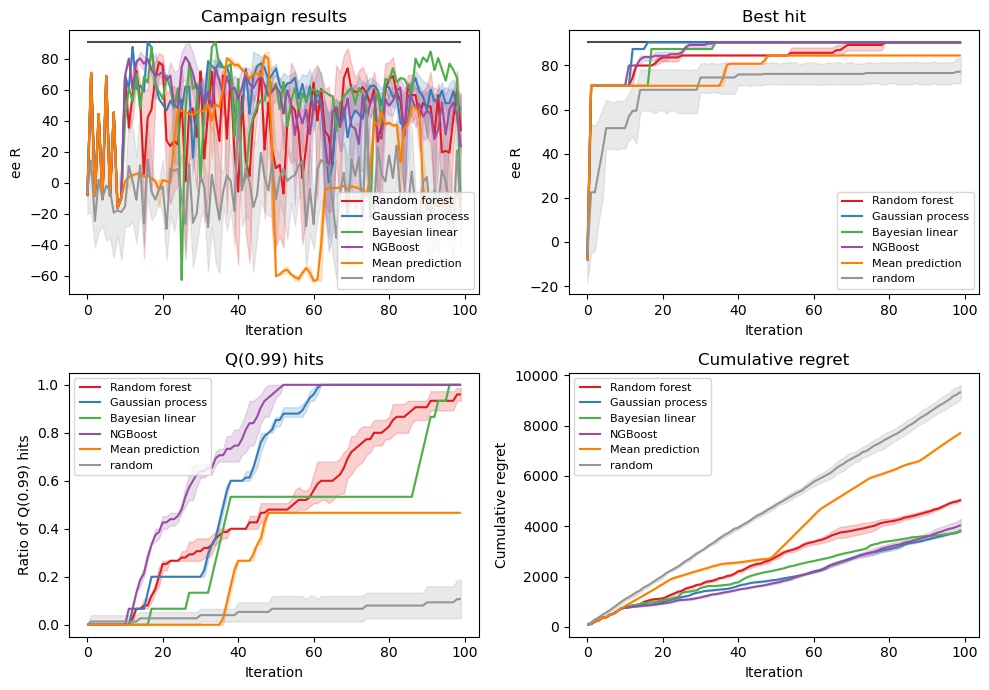

In [57]:
from utils import plot_results

plot_results(results, lookup, figure_name='bo_surrogates.png', nbr_controls=1)